# Making modeling scheme validation figures using 3 taxa

* Taxa differing in G+C content
  * low GC = 
  * mid GC = E. coli
  * high GC = 

### Genomic fragment simulation

* Sup Figure:
  * 3 taxa of differing GC
  * Fragment length distributions
    * 'realistic' = skewed normal
    * 'large' = ~50 kb
    * 'small' = ~1-2 kb
  * faceted heatmap:
    * taxa ~ (fragment length distribution)

### Diffusion calculations

* Sup Figure:
  * 3 taxa of differing GC (same as last)
  * histograms:
    * BD distribution for pre & post diffusion 
  * Shows effect of diffusion & how it relates to fragment length


# Setting variables

In [28]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome3/validation/'
genomeDir = '/home/nick/notebook/SIPSim/dev/bac_genome3/genomes/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'
figDir = '/home/nick/notebook/SIPSim/figures/'

bandwidth=0.2
nprocs = 3

# Init

In [29]:
import os
import glob
import nestly
from IPython.display import Image
import dill
import numpy as np                                                              
import pandas as pd                                                             
import scipy.stats as stats

In [30]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [31]:
%%R
library(ggplot2)
library(plyr)
library(dplyr)
library(tidyr)
library(gridExtra)

In [32]:
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
%cd $workDir    

/home/nick/notebook/SIPSim/dev/bac_genome3/validation


# Simulating fragments

  * Fragment length distributions
    * 'realistic' = skewed normal
    * 'large' = ~50 kb
    * 'small' = ~1-2 kb

In [33]:
# skewed-normal
!SIPSim fragments \
    $genomeDir/genome_index.txt \
    --fp $genomeDir \
    --fr ../../515F-806R.fna \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np $nprocs \
    --tbl \
    2> ampFrags_real.log \
    > ampFrags_real.txt       

In [34]:
# uniform (small)
!SIPSim fragments \
    $genomeDir/genome_index.txt \
    --fp $genomeDir \
    --fr ../../515F-806R.fna \
    --fld uniform,1000,2000 \
    --flr None,None \
    --nf 10000 \
    --np $nprocs \
    --tbl \
    2> ampFrags_sm.log \
    > ampFrags_sm.txt       

In [35]:
# uniform (largs)
!SIPSim fragments \
    $genomeDir/genome_index.txt \
    --fp $genomeDir \
    --fr ../../515F-806R.fna \
    --fld uniform,50000,51000 \
    --flr None,None \
    --nf 10000 \
    --np $nprocs \
    --tbl \
    2> ampFrags_lg.log \
    > ampFrags_lg.txt       

## Plotting fragments

In [36]:
%%R -i workDir
setwd(workDir)

files = c('ampFrags_real.txt',
          'ampFrags_sm.txt',
          'ampFrags_lg.txt')

tbl.l = list()
for(f in files){
    tbl.l[[f]] = read.delim(f, sep='\t')
    }
tbl = do.call(rbind, tbl.l)
tbl %>% head(n=3)

                                           taxon_name
ampFrags_real.txt.1 Clostridium_ljungdahlii_DSM_13528
ampFrags_real.txt.2 Clostridium_ljungdahlii_DSM_13528
ampFrags_real.txt.3 Clostridium_ljungdahlii_DSM_13528
                                                    scaffoldID fragStart
ampFrags_real.txt.1 CP001666_Clostridium_ljungdahlii_DSM_13528   4480839
ampFrags_real.txt.2 CP001666_Clostridium_ljungdahlii_DSM_13528     86453
ampFrags_real.txt.3 CP001666_Clostridium_ljungdahlii_DSM_13528    110150
                    fragLength   fragGC
ampFrags_real.txt.1       7913 42.33540
ampFrags_real.txt.2       8254 33.72910
ampFrags_real.txt.3       9318 40.66323


In [37]:
%%R
tbl$fld = gsub('\\.txt.+', '', rownames(tbl))
tbl %>% head(n=3)

                                           taxon_name
ampFrags_real.txt.1 Clostridium_ljungdahlii_DSM_13528
ampFrags_real.txt.2 Clostridium_ljungdahlii_DSM_13528
ampFrags_real.txt.3 Clostridium_ljungdahlii_DSM_13528
                                                    scaffoldID fragStart
ampFrags_real.txt.1 CP001666_Clostridium_ljungdahlii_DSM_13528   4480839
ampFrags_real.txt.2 CP001666_Clostridium_ljungdahlii_DSM_13528     86453
ampFrags_real.txt.3 CP001666_Clostridium_ljungdahlii_DSM_13528    110150
                    fragLength   fragGC           fld
ampFrags_real.txt.1       7913 42.33540 ampFrags_real
ampFrags_real.txt.2       8254 33.72910 ampFrags_real
ampFrags_real.txt.3       9318 40.66323 ampFrags_real


In [38]:
%%R 

fld.revalue = c('ampFrags_real' = 'skewed normal (mean = 9 kb)',
                  'ampFrags_sm' = 'uniform (1-2 kb)',
                  'ampFrags_lg' = 'uniform (50-51 kb)')

taxon.revalue = c('Clostridium_ljungdahlii_DSM_13528' = 'Clostridium_ljungdahlii\nDSM_13528',
                  'Streptomyces_pratensis_ATCC_33331' = 'Streptomyces_pratensis\nATCC_33331')


tbl.f = tbl %>%
    mutate(taxon_name = revalue(taxon_name, taxon.revalue),
           fld = revalue(fld, fld.revalue)) %>%
    mutate(taxon_name = gsub('_', ' ', taxon_name))

tbl.f %>% head(n=3)

                          taxon_name                                 scaffoldID
1 Clostridium ljungdahlii\nDSM 13528 CP001666_Clostridium_ljungdahlii_DSM_13528
2 Clostridium ljungdahlii\nDSM 13528 CP001666_Clostridium_ljungdahlii_DSM_13528
3 Clostridium ljungdahlii\nDSM 13528 CP001666_Clostridium_ljungdahlii_DSM_13528
  fragStart fragLength   fragGC                         fld
1   4480839       7913 42.33540 skewed normal (mean = 9 kb)
2     86453       8254 33.72910 skewed normal (mean = 9 kb)
3    110150       9318 40.66323 skewed normal (mean = 9 kb)


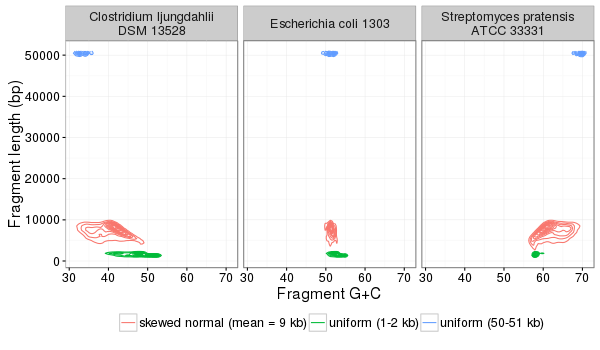

In [39]:
%%R -w 600 -h 350

ggplot(tbl.f, aes(fragGC, fragLength, color=fld)) +
    stat_density2d() +
    scale_color_discrete(name='') +
    labs(x='Fragment G+C', y='Fragment length (bp)') +
    facet_grid(. ~ taxon_name) +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.title.y=element_text(vjust=1),
        legend.position = 'bottom'
        )

In [40]:
%%R -i figDir

outFile = paste(c(figDir, 'genome3_fragKDE.pdf'), collapse='/')
ggsave(outFile, width=10, height=4)

# Converting to KDE

In [43]:
!SIPSim fragment_KDE \
    ampFrags_real.txt \
    > ampFrags_real_kde.pkl
    
!SIPSim fragment_KDE \
    ampFrags_sm.txt \
    > ampFrags_sm_kde.pkl
    
!SIPSim fragment_KDE \
    ampFrags_lg.txt \
    > ampFrags_lg_kde.pkl    

# Adding diffusion

In [51]:
!SIPSim diffusion \
    ampFrags_real_kde.pkl \
    --bw $bandwidth \
    --np $nprocs \
    > ampFrags_real_kde_dif.pkl    
    
!SIPSim diffusion \
    ampFrags_sm_kde.pkl \
    --bw $bandwidth \
    --np $nprocs \
    > ampFrags_sm_kde_dif.pkl    
    
!SIPSim diffusion \
    ampFrags_lg_kde.pkl \
    --bw $bandwidth \
    --np $nprocs \
    > ampFrags_lg_kde_dif.pkl        

Index size: 90508
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303
Processing: Clostridium_ljungdahlii_DSM_13528
Index size: 90508
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303
Processing: Clostridium_ljungdahlii_DSM_13528
Index size: 90508
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303
Processing: Clostridium_ljungdahlii_DSM_13528


# Plotting fragment distribution w/ and w/out diffusion

## Making a table of fragment values from KDEs

In [52]:
%%bash 

n=100000

SIPSim KDE_sample -n $n ampFrags_real_kde.pkl > ampFrags_real_kde.txt
SIPSim KDE_sample -n $n ampFrags_real_kde_dif.pkl > ampFrags_real_kde_dif.txt

SIPSim KDE_sample -n $n ampFrags_sm_kde.pkl > ampFrags_sm_kde.txt
SIPSim KDE_sample -n $n ampFrags_sm_kde_dif.pkl > ampFrags_sm_kde_dif.txt

SIPSim KDE_sample -n $n ampFrags_lg_kde.pkl > ampFrags_lg_kde.txt
SIPSim KDE_sample -n $n ampFrags_lg_kde_dif.pkl > ampFrags_lg_kde_dif.txt

## Plotting

In [53]:
%%R -i workDir

kde.files = c('ampFrags_real_kde.txt',
              'ampFrags_sm_kde.txt',
              'ampFrags_lg_kde.txt')
kde.dif.files = c('ampFrags_real_kde_dif.txt',
                  'ampFrags_sm_kde_dif.txt',
                  'ampFrags_lg_kde_dif.txt')


load.tables = function(files, data.id){
    tbl.l = list()
    for(f in files){
        F = file.path(workDir, f)
        x = read.delim(F, sep='\t')
        x = mutate(x, 
                   data = data.id,
                   fld = gsub('_kde(_dif)*.txt', '', f))
        tbl.l[[f]] = x
        }
    
    tbl = do.call(rbind, tbl.l) %>%
        gather('taxon_name','BD', 2:4)
    return(tbl)
    }

tbl1 = load.tables(kde.files, 'no diffusion')
tbl2 = load.tables(kde.dif.files, 'diffusion')
tbl = rbind(tbl1, tbl2)
tbl %>% head(n=3)

  X libID         data           fld                        taxon_name       BD
1 0     1 no diffusion ampFrags_real Clostridium_ljungdahlii_DSM_13528 1.694562
2 1     1 no diffusion ampFrags_real Clostridium_ljungdahlii_DSM_13528 1.700353
3 2     1 no diffusion ampFrags_real Clostridium_ljungdahlii_DSM_13528 1.702735


In [54]:
%%R 

fld.revalue = c('ampFrags_real' = 'skewed normal\n(mean = 9 kb)',
                'ampFrags_sm' = 'uniform\n(1-2 kb)',
                'ampFrags_lg' = 'uniform\n(50-51 kb)')

taxon.revalue = c('Clostridium_ljungdahlii_DSM_13528' = 'Clostridium_ljungdahlii\nDSM_13528',
                  'Streptomyces_pratensis_ATCC_33331' = 'Streptomyces_pratensis\nATCC_33331')


tbl.f = tbl %>%
    mutate(taxon_name = revalue(taxon_name, taxon.revalue),
           fld = revalue(fld, fld.revalue)) %>%
    mutate(taxon_name = gsub('_', ' ', taxon_name))

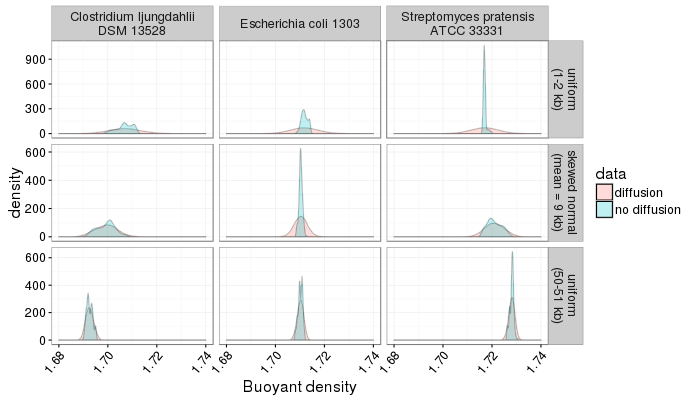

In [55]:
%%R -w 700 -h 400

tbl.f$fld = factor(tbl.f$fld, 
                   levels=c('uniform\n(1-2 kb)','skewed normal\n(mean = 9 kb)','uniform\n(50-51 kb)'))


ggplot(tbl.f, aes(BD, fill=data)) +
    geom_density(alpha=0.25) +
    scale_x_continuous(limits=c(1.68, 1.74)) +
    facet_grid(fld ~ taxon_name, scales='free_y') +    
    labs(x = 'Buoyant density') +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.title.y = element_text(vjust=1),
        axis.text.x = element_text(angle=50, hjust=1)
        )

In [56]:
%%R -i figDir 

outFile = paste(c(figDir, 'genome3_fragKDE_dif.pdf'), collapse='/')
ggsave(outFile, width=10, height=5.71) 

# Adding DBL 'smearing' to diffusion KDEs

In [57]:
# fraction of fragments in DBL
frac_abs = 0.001

!SIPSim DBL \
    ampFrags_real_kde_dif.pkl \
    --frac_abs $frac_abs \
    --bw $bandwidth \
    --np $nprocs \
    > ampFrags_real_kde_dif_DBL.pkl    
    
!SIPSim DBL \
    ampFrags_sm_kde_dif.pkl \
    --frac_abs $frac_abs \
    --bw $bandwidth \
    --np $nprocs \
    > ampFrags_sm_kde_dif_DBL.pkl    
    
!SIPSim DBL \
    ampFrags_lg_kde_dif.pkl \
    --frac_abs $frac_abs \
    --bw $bandwidth \
    --np $nprocs \
    > ampFrags_lg_kde_dif_DBL.pkl        

DBL_index file written: "DBL_index.txt"
Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303
DBL_index file written: "DBL_index.txt"
Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303
DBL_index file written: "DBL_index.txt"
Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303


In [58]:
# viewing DBL logs
g_path = os.path.join(workDir, '*_DBL.log')
files = glob.glob(g_path)
for f in files:
    !tail $f

Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303
Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303
Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303


## Making a table of fragment values from KDEs

In [59]:
%%bash -s "$workDir"

n=100000

SIPSim KDE_sample -n $n ampFrags_real_kde_dif_DBL.pkl > ampFrags_real_kde_dif_DBL.txt
SIPSim KDE_sample -n $n ampFrags_sm_kde_dif_DBL.pkl > ampFrags_sm_kde_dif_DBL.txt
SIPSim KDE_sample -n $n ampFrags_lg_kde_dif_DBL.pkl > ampFrags_lg_kde_dif_DBL.txt

## Plotting fragment BD distributions (no DBL vs DBL)

In [60]:
%%R -i workDir

kde.dif.files = c('ampFrags_real_kde_dif.txt',
                  'ampFrags_sm_kde_dif.txt',
                  'ampFrags_lg_kde_dif.txt')
kde.DBL.files = c('ampFrags_real_kde_dif_DBL.txt',
                  'ampFrags_sm_kde_dif_DBL.txt',
                  'ampFrags_lg_kde_dif_DBL.txt')


load.tables = function(files, data.id){
    tbl.l = list()
    for(f in files){
        F = file.path(workDir, f)
        x = read.delim(F, sep='\t') %>%
                mutate(data = data.id,
                       fld = gsub('_kde_dif(_DBL)*.txt', '', f))
        if (!any('libID' %in% colnames(x))){
            x$libID = '1'
        }
        tbl.l[[f]] = x
        }
    
    tbl = do.call(rbind, tbl.l) %>%
        gather('taxon_name','BD', 2:4)
    return(tbl)
    }

tbl1 = load.tables(kde.dif.files, 'diffusion')
tbl2 = load.tables(kde.DBL.files, 'diffusion_wDBL')
tbl = rbind(tbl1, tbl2)
tbl %>% head(n=3)

  X libID      data           fld                        taxon_name       BD
1 0     1 diffusion ampFrags_real Clostridium_ljungdahlii_DSM_13528 1.695162
2 1     1 diffusion ampFrags_real Clostridium_ljungdahlii_DSM_13528 1.707110
3 2     1 diffusion ampFrags_real Clostridium_ljungdahlii_DSM_13528 1.701430


In [61]:
%%R 

fld.revalue = c('ampFrags_real' = 'skewed normal\n(mean = 9 kb)',
                'ampFrags_sm' = 'uniform\n(1-2 kb)',
                'ampFrags_lg' = 'uniform\n(50-51 kb)')

taxon.revalue = c('Clostridium_ljungdahlii_DSM_13528' = 'Clostridium_ljungdahlii\nDSM_13528',
                  'Streptomyces_pratensis_ATCC_33331' = 'Streptomyces_pratensis\nATCC_33331')


tbl.f = tbl %>%
    mutate(taxon_name = revalue(taxon_name, taxon.revalue),
           fld = revalue(fld, fld.revalue)) %>%
    mutate(taxon_name = gsub('_', ' ', taxon_name))

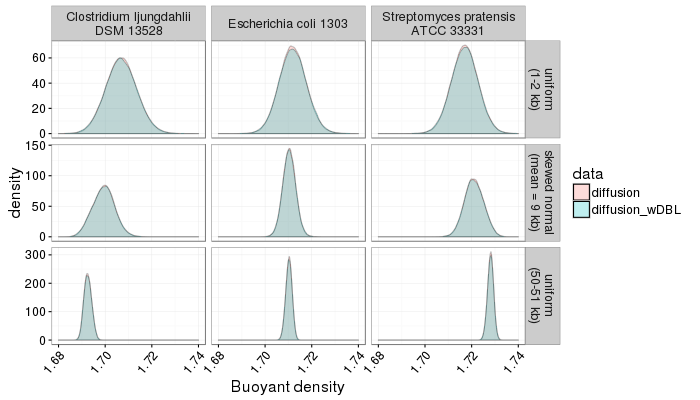

In [67]:
%%R -w 700 -h 400

tbl.f$fld = factor(tbl.f$fld, 
                   levels=c('uniform\n(1-2 kb)','skewed normal\n(mean = 9 kb)','uniform\n(50-51 kb)'))


p1 = ggplot(tbl.f, aes(BD, fill=data)) +
    geom_density(alpha=0.25) +
    scale_x_continuous(limits=c(1.68, 1.74)) +
    facet_grid(fld ~ taxon_name, scales='free_y') +    
    labs(x = 'Buoyant density') +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.title.y = element_text(vjust=1),
        axis.text.x = element_text(angle=50, hjust=1)
        )
p1

In [68]:
%%R -w 700 -h 400
p2 = p1 + scale_y_log10() 

# Adding abundance-weighted DBL smearing

In [64]:
# getting file listing taxon names
!SIPSim KDE_info \
    -t ampFrags.pkl \
    > taxon_names.txt
    
!head taxon_names.txt    

Loading KDEs...
Clostridium_ljungdahlii_DSM_13528
Escherichia_coli_1303
Streptomyces_pratensis_ATCC_33331


In [65]:
# making a community file
comm_params = 'mean:-9.5,sigma:0.9'

!SIPSim communities \
    --abund_dist_p $comm_params \
    taxon_names.txt \
    > comm.txt
    
!head comm.txt    

library	taxon_name	rel_abund_perc	rank
1	Streptomyces_pratensis_ATCC_33331	48.614330446	1
1	Escherichia_coli_1303	29.238216324	2
1	Clostridium_ljungdahlii_DSM_13528	22.147453230	3


In [66]:
# fraction of fragments in DBL

!SIPSim DBL \
    ampFrags_real_kde_dif.pkl \
    --frac_abs $frac_abs \
    --comm comm.txt \
    --bw $bandwidth \
    --np $nprocs \
    > ampFrags_real_kde_dif_DBL-comm.pkl    
    
!SIPSim DBL \
    ampFrags_sm_kde_dif.pkl \
    --frac_abs $frac_abs \
    --comm comm.txt \
    --bw $bandwidth \
    --np $nprocs \
    > ampFrags_sm_kde_dif_DBL-comm.pkl    
    
!SIPSim DBL \
    ampFrags_lg_kde_dif.pkl \
    --frac_abs $frac_abs \
    --comm comm.txt \
    --bw $bandwidth \
    --np $nprocs \
    > ampFrags_lg_kde_dif_DBL-comm.pkl        

DBL_index file written: "DBL_index.txt"
Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303
DBL_index file written: "DBL_index.txt"
Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303
DBL_index file written: "DBL_index.txt"
Processing: Clostridium_ljungdahlii_DSM_13528
Processing: Streptomyces_pratensis_ATCC_33331
Processing: Escherichia_coli_1303
